In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import abc

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch import Tensor
import matplotlib.pyplot as plt

from models.ridge_ALOOCV import fit_ridge_ALOOCV
from models.sandwiched_least_squares import sandwiched_LS_dense, sandwiched_LS_diag, sandwiched_LS_scalar

def acc_from_logits(logits, y, n_classes):
    if n_classes==2:
        pred = (logits>0).float()
    else:
        pred = torch.argmax(logits, dim=1)
        y = torch.argmax(y, dim=1)
    acc = (pred==y).float().mean()
    return acc



def generate_concentric_rings(n_rings_per_class=2, n_classes=3, n_samples=2000, device="cpu", plot=False) -> Tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    n_rings = n_rings_per_class * n_classes
    samples_per_ring = n_samples // n_rings
    for i in range(n_rings):
        radius = i + 1
        theta = np.linspace(0, 2 * np.pi, samples_per_ring)
        noise_scale = 0.5
        x1 = radius * np.cos(theta) + np.random.rand(samples_per_ring) * noise_scale
        x2 = radius * np.sin(theta) + np.random.rand(samples_per_ring) * noise_scale
        X.append(np.vstack((x1, x2)).T)
        y.append(np.full(samples_per_ring, i % n_classes))
    X = np.vstack(X)
    y = np.hstack(y)
    perm = np.random.permutation(len(X))
    X = X[perm] / np.max(X)
    y = y[perm]

    #plot
    if plot:
        plt.figure(figsize=(8, 8))
        for i in range(n_classes):
            plt.scatter(X[y == i][:, 0], X[y == i][:, 1], label=f'Class {i}')
        plt.legend()
        plt.title('Concentric Rings Dataset')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

    y = torch.tensor(y).float()
    X = torch.tensor(X).float()
    if n_classes > 2:
        y = torch.nn.functional.one_hot(y.to(torch.int64), n_classes).float()
    else:
        y = y.unsqueeze(1)

    r = int(0.5 * len(X))
    X_train, y_train, X_test, y_test = X[:r], y[:r], X[r:], y[r:]
    return (X_train.to(device),
            y_train.to(device), 
            X_test.to(device), 
            y_test.to(device) )




# Generate dataset
# n_classes = 2
# D = 10
# X_train, y_train, X_test, y_test = make_spirals_dataset_Rd(
#     n_samples=1000, n_classes=n_classes, noise=0.1, D=D, train_test_ratio=0.8
#     )
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
n_classes = 3
D = 2
device = "cuda"
X_train, y_train, X_test, y_test = generate_concentric_rings(
    n_rings_per_class=3, n_classes=n_classes, n_samples=10000, device=device
    )
if n_classes > 2:
    loss_fn = nn.functional.cross_entropy
else:
    loss_fn = nn.functional.binary_cross_entropy_with_logits

In [2]:
from models.base import LogisticRegression
    
model = LogisticRegression(
    n_classes, l2_lambda=0.1, max_iter=100
     )

results = []
for i in range(5):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

train ce tensor(1.0986) std tensor(0.)
test ce tensor(1.0987) std tensor(3.7697e-07)
train acc tensor(0.3410) std tensor(0.0009)
test acc tensor(0.3372) std tensor(0.0009)


In [6]:
#from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.random_feature_representation_boosting import GradientRFRBoostClassifier

seed=2
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = GradientRFRBoostClassifier(
        in_dim=D,
        n_classes=n_classes,
        hidden_dim=2,
        n_layers=4,
        randfeat_xt_dim=512,
        randfeat_x0_dim=512,
        l2_cls=0.01,
        l2_ghat=0.0001,
        boost_lr=1.0,
        feature_type="SWIM",
        upscale_type="identity",
        lbfgs_lr=1.0,
        lbfgs_max_iter=300,
        use_batchnorm=True,
    )

results = []
for i in range(1):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

train ce tensor(0.07215128839015960693) std tensor(nan)
test ce tensor(0.09010142087936401367) std tensor(nan)
train acc tensor(0.99179840087890625000) std tensor(nan)
test acc tensor(0.98539996147155761719) std tensor(nan)


/tmp/ipykernel_43476/1699865975.py:37: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
/tmp/ipykernel_43476/1699865975.py:38: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
/tmp/ipykernel_43476/1699865975.py:39: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
/tmp/ipykernel_4347

Train ce at layer 0: 1.0985674858093262
Test ce at layer 0: 1.0987236499786377
Train acc at layer 0: 0.3868773877620697
Test acc at layer 0: 0.37880000472068787



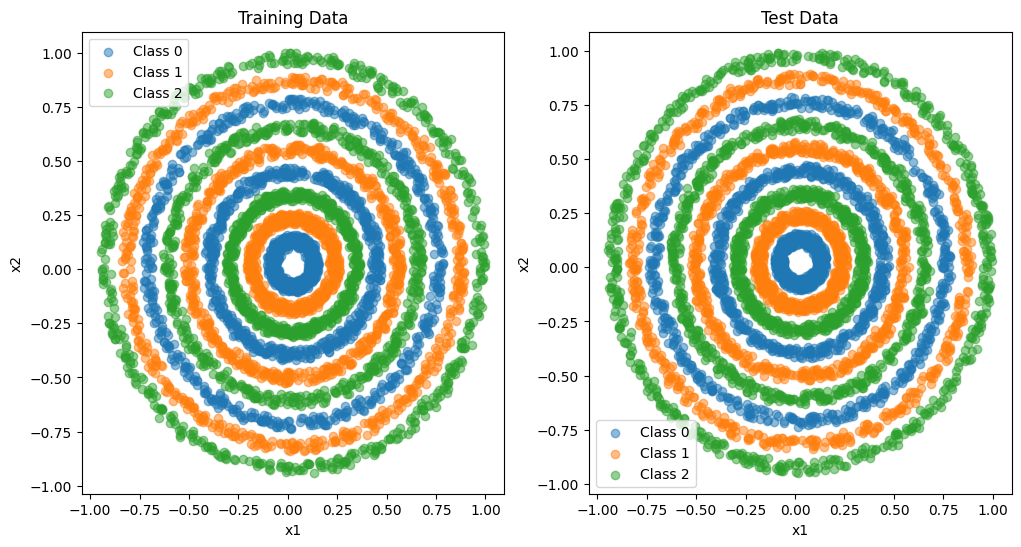

Train ce at layer 1: 0.26323121786117554
Test ce at layer 1: 0.2910398244857788
Train acc at layer 1: 0.9431886672973633
Test acc at layer 1: 0.9296000003814697



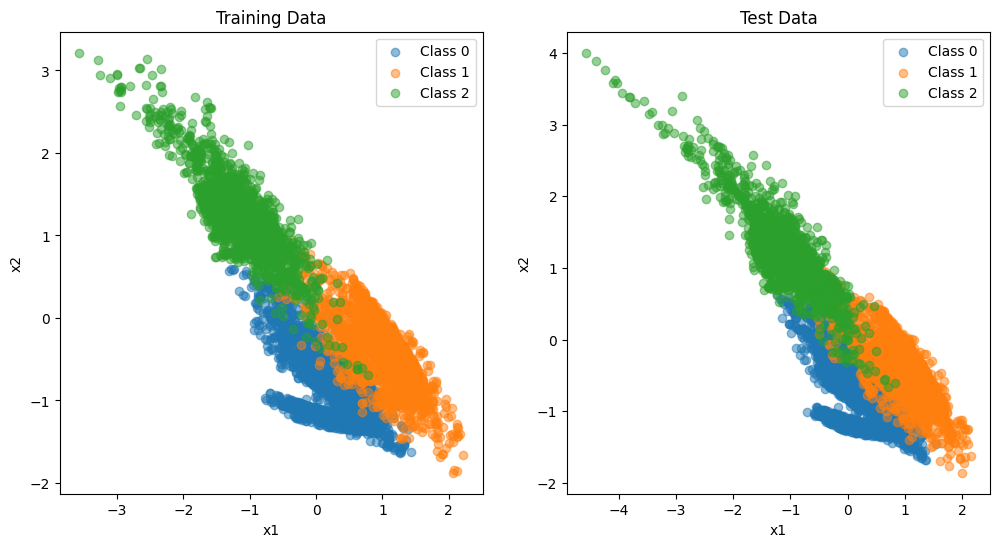

Train ce at layer 2: 0.11813215166330338
Test ce at layer 2: 0.14139488339424133
Train acc at layer 2: 0.9783957004547119
Test acc at layer 2: 0.9687999486923218



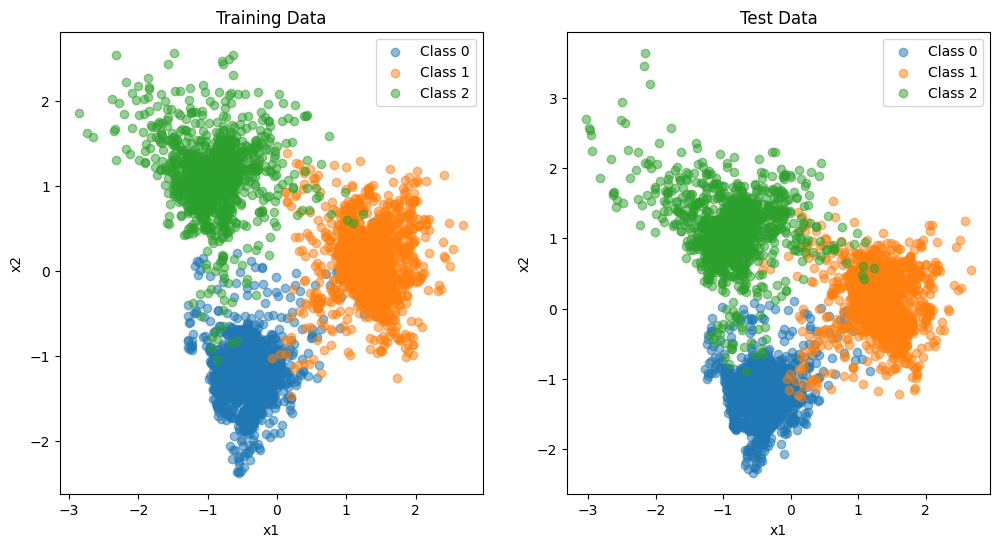

Train ce at layer 3: 0.08808384090662003
Test ce at layer 3: 0.1006074920296669
Train acc at layer 3: 0.991398274898529
Test acc at layer 3: 0.9851999878883362



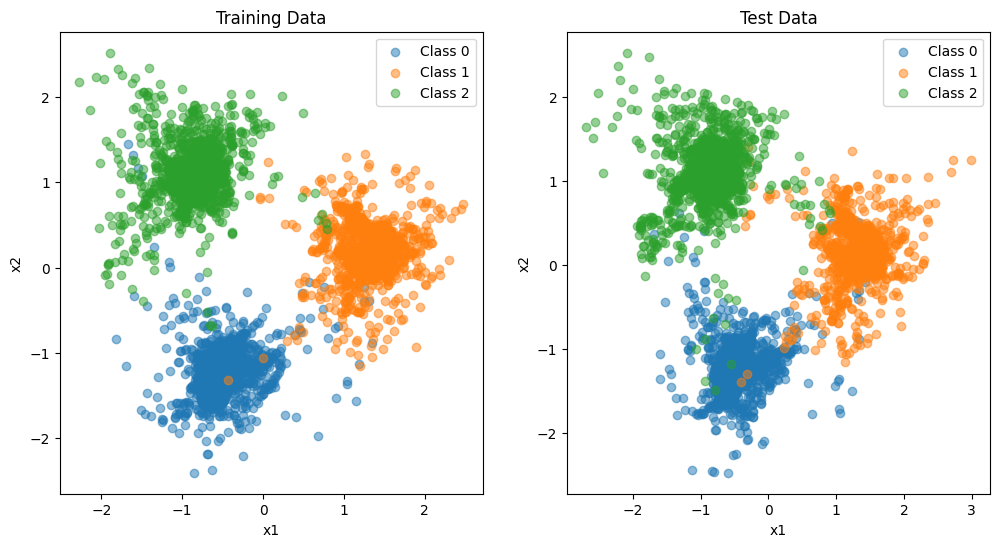

Train ce at layer 4: 0.0721512883901596
Test ce at layer 4: 0.09010142087936401
Train acc at layer 4: 0.9917984008789062
Test acc at layer 4: 0.9853999614715576



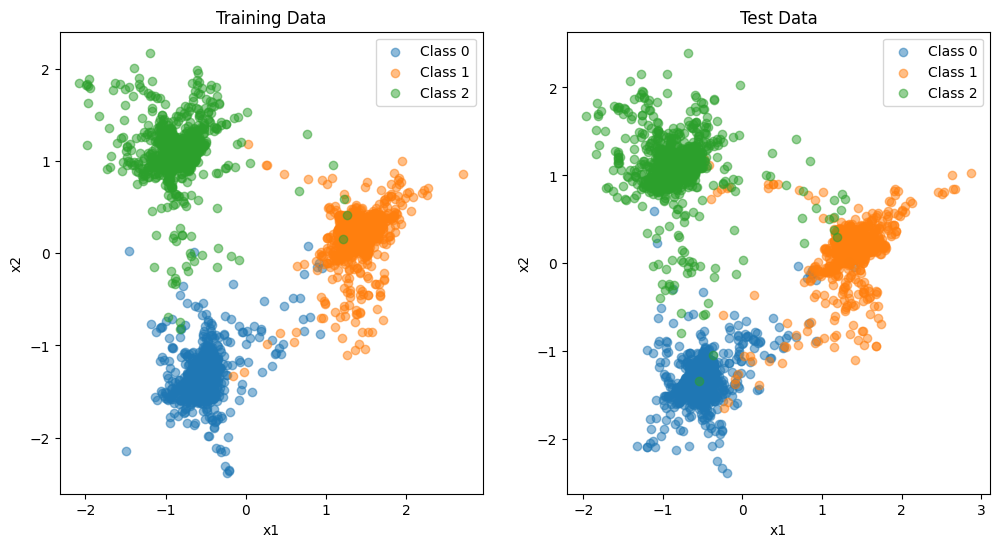

In [7]:
def plot_features(X_train, y_train, X_test, y_test):
        plt.figure(figsize=(12, 6))

        if y_train.size(1) == 1:
            y_train = torch.nn.functional.one_hot(y_train[:, 0].to(torch.int64), 2).float()
            y_test = torch.nn.functional.one_hot(y_test[:, 0].to(torch.int64), 2).float()

        X_train = X_train.cpu().numpy()
        y_train = y_train.cpu().numpy()
        X_test = X_test.cpu().numpy()
        y_test = y_test.cpu().numpy()

        alpha = 0.5  # Set the transparency level

        plt.subplot(1, 2, 1)
        for i in range(n_classes):
            plt.scatter(X_train[y_train[:, i] == 1][:, 0], X_train[y_train[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
        plt.title('Training Data')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()

        plt.subplot(1, 2, 2)
        for i in range(n_classes):
            plt.scatter(X_test[y_test[:, i] == 1][:, 0], X_test[y_test[:, i] == 1][:, 1], label=f'Class {i}', alpha=alpha)
        plt.title('Test Data')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()

        plt.show()


def see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        X_train = model.upscale(X0_train)
        X_test = model.upscale(X0_test)

        pred_train = model.top_level_modules[0](X_train)
        pred_test = model.top_level_modules[0](X_test)

        ce_train = loss_fn(pred_train, y_train)
        ce_test = loss_fn(pred_test, y_test)
        acc_train = acc_from_logits(pred_train, y_train, n_classes)
        acc_test = acc_from_logits(pred_test, y_test, n_classes)
        print(f"Train ce at layer 0: {ce_train}")
        print(f"Test ce at layer 0: {ce_test}")
        print(f"Train acc at layer 0: {acc_train}")
        print(f"Test acc at layer 0: {acc_test}")
        print()
        plot_features(X_train, y_train, X_test, y_test)
        
        for t, (feat_layer, ghat_layer, classifier, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.top_level_modules[1:],
                                                                     model.batchnorms)):
            features_train = feat_layer(X_train, X0_train)
            features_test = feat_layer(X_test, X0_test)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            
            pred_train = classifier(X_train)
            pred_test = classifier(X_test)

            ce_train = loss_fn(pred_train, y_train)
            ce_test = loss_fn(pred_test, y_test)
            acc_train = acc_from_logits(pred_train, y_train, n_classes)
            acc_test = acc_from_logits(pred_test, y_test, n_classes)

            print(f"Train ce at layer {t+1}: {ce_train}")
            print(f"Test ce at layer {t+1}: {ce_test}")
            print(f"Train acc at layer {t+1}: {acc_train}")
            print(f"Test acc at layer {t+1}: {acc_test}")
            print()
            plot_features(X_train, y_train, X_test, y_test)

see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn)


# End2End

In [5]:
from models.end2end import End2EndMLPResNet

n_blocks = 4
model = End2EndMLPResNet(
        in_dim=2,
        hidden_dim=2,
        bottleneck_dim=512,
        out_dim= (n_classes if n_classes>2 else 1),
        n_blocks=n_blocks,
        loss = ("cce" if n_classes>2 else "bce"),
        lr = 0.0001,
        n_epochs = 30,
        end_lr_factor= 0.01,
        weight_decay = 0.00001,
        batch_size = 64,
        upsample = False,
        activation = nn.Tanh(),
        )

results = []
for i in range(1):
    model.fit(X_train, y_train)
    model.eval()
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

 80%|████████  | 24/30 [00:12<00:03,  1.87it/s]


KeyboardInterrupt: 

In [ ]:
def plot_resnet(X_train, y_train, X_test, y_test, model):
    with torch.no_grad():
        # for each layer, calculate the activations, and plot
        X_train = model.upsample(X_train)
        X_test = model.upsample(X_test)
        plot_features(X_train, y_train, X_test, y_test)

        for t in range(n_blocks):
            X_train = X_train + model.residual_blocks[t](X_train)
            X_test = X_test + model.residual_blocks[t](X_test)
            plot_features(X_train, y_train, X_test, y_test)
plot_resnet(X_train, y_train, X_test, y_test, model)

# How do i want to set up the experiments?

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from models.base import FittableModule

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class SKLearnWrapper(BaseEstimator):
    def __init__(self, modelClass=None, **model_params):
        self.modelClass = modelClass
        self.model_params = model_params
        self.seed = None
        self.model = None

    def fit(self, X, y):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)

        self.model = self.modelClass(**self.model_params)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def set_params(self, **params):
        self.modelClass = params.pop('modelClass', self.modelClass)
        self.seed = params.pop('seed', self.seed)
        self.model_params.update(params)
        return self

    def get_params(self, deep=True):
        params = {'modelClass': self.modelClass}
        params.update(self.model_params)
        return params
    
    def score(self, X, y):
        logits = self.model(X)
        if y.size(1) == 1:
            pred = (logits>0).float()
        else:
            pred = torch.argmax(logits, dim=1)
            y = torch.argmax(y, dim=1)
        acc = (pred==y).float().mean()
        print(acc)
        return acc.detach().cpu().item()
    
    def set_model_eval(self):
        self.model.eval()
    

import matplotlib.patches as patches

def save_feature_plot(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        model, 
        n_classes, 
        file_name: str,
        save_dir: str = "save/ConcentricCircles/"
        ):
    """
    Saves train and test features side by side for visualization at a given layer.
    
    Args:
        X_train (torch.Tensor): Features of the training set (shape: [n_samples, 2]).
        y_train (torch.Tensor): Labels of the training set (one-hot or integer-encoded).
        X_test (torch.Tensor): Features of the test set (shape: [n_samples, 2]).
        y_test (torch.Tensor): Labels of the test set (one-hot or integer-encoded).
        n_classes (int): Number of classes in the dataset.
        file_name (str): Name of the file to save the plot.
        save_dir (str): Directory to save the plot.
    """
    # Obtain the features at each layer
    train_features = [X_train]
    test_features = [X_test]
    if type(model) == GradientRFRBoostClassifier:
        X0_train = X_train
        X0_test = X_test
        for t, (feat_layer, ghat_layer, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.batchnorms)):
            model.train()
            features_train = feat_layer(X_train, X0_train)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            model.eval()
            features_test = feat_layer(X_test, X0_test)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    elif type(model) == End2EndMLPResNet:
        for resblock in model.residual_blocks:
            X_train = X_train + resblock(X_train)
            X_test = X_test + resblock(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    else:
        raise ValueError("Model type not recognized.")
    
    # Convert labels to integers if they're one-hot encoded
    train_labels_np = y_train.argmax(dim=1).cpu().numpy() if n_classes > 2 else y_train.cpu().numpy()
    test_labels_np = y_test.argmax(dim=1).cpu().numpy() if n_classes > 1 else y_test.cpu().numpy()


    # Plot the features
    T = len(train_features)
    for name_train_or_test, features, labels in [("train", train_features, train_labels_np), 
                                                 ("test", test_features, test_labels_np)]:
        fig, axes = plt.subplots(1, T, figsize=(T * 4, 4), dpi=100)
        for t in range(T):
            ax = axes[t]
            feat = features[t].detach().cpu().numpy()
            for j in range(feat.shape[1]):
                feat[:, j] = (feat[:, j] - feat[:, j].min()) / (feat[:, j].max() - feat[:, j].min())
            for i in range(n_classes):
                ax.scatter(feat[labels == i][:, 0], feat[labels == i][:, 1])

            # Remove titles and adjust axis
            ax.axis('equal')
            ax.axis('off')

            # Add black border as a rectangle
            rect = patches.Rectangle(
                (0, 0), 1, 1, transform=ax.transAxes,  # Set size relative to axes
                linewidth=2, edgecolor='black', facecolor='none', zorder=10
            )
            ax.add_patch(rect)

        # Add vertical label for the model name
        name = "MLP ResNet" if type(model) == End2EndMLPResNet else "GRFRBoost (ours)"
        if "GRFRBoost" in name:
            if model.randfeat_x0_dim == 0:
                name += " x0 only"
            if model.feature_type == "SWIM":
                name += " SWIM"
        fig.text(0.02, 0.5, name, fontsize=18, rotation='vertical', va='center', ha='center')

        plt.tight_layout()
        plt.subplots_adjust(left=0.03)  # Add space for the model name
        plt.savefig(f"{save_dir}/{file_name}_{name_train_or_test}.png", bbox_inches='tight', dpi=300)
        plt.close(fig)




def run_concentric_rings_experiment(
        seed=42,
        k_folds=5,
        n_classes=3,
        n_rings_per_class=3,
        n_samples=10000,
        device="cuda",
        ):
    """Runs the concentric circle experiments and saves the plots and results."""
    # Define models and their hyperparameter grids
    n_layers = 4 # TODO CHANGE
    bottleneck_dim = 512
    use_batchnorm = True
    model_specs = {
        "GradientRFRBoost": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, -1, 4),
            'l2_ghat': np.logspace(-6, -3, 4),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'feature_type': ["iid"],
            'upscale_type': ["identity"],
            'use_batchnorm': [use_batchnorm],
            'lbfgs_max_iter': [300],
            'lbfgs_lr': [1.0],
        },
        "GradientRFRBoost SWIM": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, -1, 4),
            'l2_ghat': np.logspace(-6, -3, 4),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'feature_type': ["SWIM"],
            'upscale_type': ["identity"],
            'use_batchnorm': [use_batchnorm],
            'lbfgs_max_iter': [300],
            'lbfgs_lr': [1.0],
        },
        "Logistic Regression": {
            'modelClass': [LogisticRegression],
            'l2_lambda': np.logspace(-4, -1, 4),
            'n_classes': [n_classes],
        },
        "End2EndMLP": {
            'modelClass': [End2EndMLPResNet],
            'lr': np.logspace(-6, -1, 6),
            'in_dim': [2],
            'hidden_dim': [2],
            'bottleneck_dim': [bottleneck_dim],
            'out_dim': [n_classes if n_classes > 2 else 1],
            'n_blocks': [n_layers],
            'loss': ["cce" if n_classes > 2 else "bce"],
            'n_epochs': [30],
            'end_lr_factor': [0.01],
            'weight_decay': [0.00001],
            'batch_size': [64],
            'upsample': [False],
            'activation': [nn.Tanh()],
        },
    }

    # Run experiments
    results = {}
    results_params = {}
    for model_name, param_grid in model_specs.items():
        accuracies = []
        best_params = []
        for i in range(5):
            # Set seed
            np.random.seed(seed+i)
            torch.manual_seed(seed+i)
            torch.cuda.manual_seed(seed+i)

            # Create dataset
            X_train, y_train, X_test, y_test = generate_concentric_rings(
                n_rings_per_class, n_classes, n_samples, device
            )

            # Perform grid search with k-fold cross-validation
            estimator = SKLearnWrapper()
            grid_search = GridSearchCV(
                estimator=estimator,
                param_grid= {**param_grid, **{"seed": [seed+i]}},
                cv=k_folds,
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)
            best_model.set_model_eval()
            accuracy = best_model.score(X_test, y_test)
            accuracies.append(accuracy)
            best_params.append(grid_search.best_params_)

            print(i, model_name, "test acc", accuracy, "params", grid_search.best_params_)

            if i == 0 and model_name != "Logistic Regression":
                print("plotting and saving feature evolution point cloud")
                save_feature_plot(X_train, y_train, X_test, y_test, best_model.model, n_classes, model_name)
        results[model_name] = accuracies
        results_params[model_name] = best_params

    return results, results_params

results, results_params = run_concentric_rings_experiment()

for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()

tensor(0.61900001764297485352, device='cuda:0')
tensor(0.71700000762939453125, device='cuda:0')
tensor(0.66700005531311035156, device='cuda:0')
tensor(0.32200002670288085938, device='cuda:0')
tensor(0.44444444775581359863, device='cuda:0')
tensor(0.80900001525878906250, device='cuda:0')
tensor(0.83600002527236938477, device='cuda:0')
tensor(0.86600005626678466797, device='cuda:0')
tensor(0.71800005435943603516, device='cuda:0')
tensor(0.85585582256317138672, device='cuda:0')
tensor(0.84700006246566772461, device='cuda:0')
tensor(0.61400002241134643555, device='cuda:0')
tensor(0.94200003147125244141, device='cuda:0')
tensor(0.82900005578994750977, device='cuda:0')
tensor(0.80380380153656005859, device='cuda:0')
tensor(0.72500002384185791016, device='cuda:0')
tensor(0.72900003194808959961, device='cuda:0')
tensor(0.87000006437301635742, device='cuda:0')
tensor(0.76300001144409179688, device='cuda:0')
tensor(0.77977979183197021484, device='cuda:0')
tensor(0.65000003576278686523, device='c

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


tensor(0.83059996366500854492, device='cuda:0')
0 GradientRFRBoost test acc 0.8305999636650085 params {'feature_type': 'iid', 'hidden_dim': 2, 'in_dim': 2, 'l2_cls': 0.01, 'l2_ghat': 1e-05, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 4, 'randfeat_x0_dim': 512, 'randfeat_xt_dim': 512, 'seed': 42, 'upscale_type': 'identity', 'use_batchnorm': True}
plotting and saving feature evolution point cloud
tensor(0.64900004863739013672, device='cuda:0')
tensor(0.54300004243850708008, device='cuda:0')
tensor(0.45400002598762512207, device='cuda:0')
tensor(0.52100002765655517578, device='cuda:0')
tensor(0.39839839935302734375, device='cuda:0')
tensor(0.93200004100799560547, device='cuda:0')
tensor(0.75400000810623168945, device='cuda:0')
tensor(0.77100002765655517578, device='cuda:0')
tensor(0.81000006198883056641, device='cuda:0')
tensor(0.78578579425811767578, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


tensor(0.34600001573562622070, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


tensor(0.33300000429153442383, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.33it/s]


tensor(0.36700001358985900879, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


tensor(0.32100000977516174316, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


tensor(0.33733734488487243652, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


tensor(0.35500001907348632812, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


tensor(0.33700001239776611328, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


tensor(0.36500000953674316406, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


tensor(0.30600002408027648926, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


tensor(0.32032030820846557617, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


tensor(0.40200001001358032227, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


tensor(0.41100001335144042969, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.36it/s]


tensor(0.41500002145767211914, device='cuda:0')


100%|██████████| 30/30 [00:08<00:00,  3.62it/s]


tensor(0.34800001978874206543, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


tensor(0.37737736105918884277, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


tensor(0.49000000953674316406, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


tensor(0.49600002169609069824, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.95it/s]


tensor(0.50200003385543823242, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


tensor(0.52700001001358032227, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


tensor(0.48548546433448791504, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


tensor(0.51200002431869506836, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.50600004196166992188, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.48600003123283386230, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


tensor(0.49600002169609069824, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


tensor(0.45645645260810852051, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.56900000572204589844, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.79400002956390380859, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.52600002288818359375, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


tensor(0.62600004673004150391, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.60560560226440429688, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


tensor(0.63839995861053466797, device='cuda:0')
0 End2EndMLP test acc 0.6383999586105347 params {'activation': Tanh(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.1, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 42, 'upsample': False, 'weight_decay': 1e-05}
plotting and saving feature evolution point cloud


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.33100003004074096680, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.32500001788139343262, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.33000001311302185059, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.34400001168251037598, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.31231230497360229492, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.34800001978874206543, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


tensor(0.32500001788139343262, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.33400002121925354004, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.36800003051757812500, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.33833834528923034668, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.45600003004074096680, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.44600000977516174316, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


tensor(0.45300000905990600586, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.47100001573562622070, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.41841840744018554688, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.49100002646446228027, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.43500003218650817871, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.50499999523162841797, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.53100001811981201172, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.48548546433448791504, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.55700004100799560547, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.44300001859664916992, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.41600000858306884766, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.38800001144409179688, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.39839839935302734375, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.35000002384185791016, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


tensor(0.59800004959106445312, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.40900000929832458496, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.61100000143051147461, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.40440440177917480469, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


tensor(0.49639999866485595703, device='cuda:0')
1 End2EndMLP test acc 0.49639999866485596 params {'activation': Tanh(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 43, 'upsample': False, 'weight_decay': 1e-05}


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.33900001645088195801, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.32800000905990600586, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.31700000166893005371, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.33000001311302185059, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.34334334731101989746, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.31600001454353332520, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.36600002646446228027, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.35700002312660217285, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.36700001358985900879, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


tensor(0.38238236308097839355, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.42900002002716064453, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.42100003361701965332, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.42200002074241638184, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.40800002217292785645, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.50450450181961059570, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.39600002765655517578, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.40400001406669616699, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.38700002431869506836, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.46400001645088195801, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


tensor(0.39439439773559570312, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.52100002765655517578, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.53500002622604370117, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.61000001430511474609, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.58500003814697265625, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.45445445179939270020, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.52799999713897705078, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.74400001764297485352, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.68500006198883056641, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.61900001764297485352, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.53153151273727416992, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


tensor(0.96759998798370361328, device='cuda:0')
2 End2EndMLP test acc 0.9675999879837036 params {'activation': Tanh(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.1, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 44, 'upsample': False, 'weight_decay': 1e-05}


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.27900001406669616699, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


tensor(0.31200000643730163574, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.31000000238418579102, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.31000000238418579102, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.31731730699539184570, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.34100002050399780273, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.33700001239776611328, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.35000002384185791016, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.35600000619888305664, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.33433434367179870605, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.48400002717971801758, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.39800003170967102051, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.43000000715255737305, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


tensor(0.44900003075599670410, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.41241240501403808594, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.46400001645088195801, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.41000002622604370117, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.50800001621246337891, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.47800001502037048340, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.38938939571380615234, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.55500000715255737305, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.50499999523162841797, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.40700000524520874023, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.53400003910064697266, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.53653651475906372070, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.57800000905990600586, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.55900001525878906250, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.83400005102157592773, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.59600001573562622070, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.54354351758956909180, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


tensor(0.83219999074935913086, device='cuda:0')
3 End2EndMLP test acc 0.8321999907493591 params {'activation': Tanh(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.1, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 45, 'upsample': False, 'weight_decay': 1e-05}


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.35200002789497375488, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.35100001096725463867, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.36300000548362731934, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.35800001025199890137, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


tensor(0.37437435984611511230, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.34000000357627868652, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.31900000572204589844, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


tensor(0.33700001239776611328, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.34000000357627868652, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


tensor(0.32932931184768676758, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


tensor(0.39200001955032348633, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.06it/s]


tensor(0.36800003051757812500, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.45000001788139343262, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.42300000786781311035, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.41741740703582763672, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


tensor(0.46700000762939453125, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.42800003290176391602, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.34900000691413879395, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


tensor(0.42300000786781311035, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.43743744492530822754, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.42000001668930053711, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.53400003910064697266, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


tensor(0.45100003480911254883, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


tensor(0.51200002431869506836, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.61461460590362548828, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


tensor(0.62600004673004150391, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.53900003433227539062, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


tensor(0.58100003004074096680, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


tensor(0.52700001001358032227, device='cuda:0')


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


tensor(0.36036035418510437012, device='cuda:0')


100%|██████████| 30/30 [00:09<00:00,  3.21it/s]

tensor(0.55500000715255737305, device='cuda:0')
4 End2EndMLP test acc 0.5550000071525574 params {'activation': Tanh(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 2, 'in_dim': 2, 'loss': 'cce', 'lr': 0.1, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 4, 'n_epochs': 30, 'out_dim': 3, 'seed': 46, 'upsample': False, 'weight_decay': 1e-05}
GradientRFRBoost acc 0.7533999800682067 std 0.07638188815487983
[0.8305999636650085, 0.8271999955177307, 0.6395999789237976, 0.7802000045776367, 0.6893999576568604]

GradientRFRBoost SWIM acc 0.9799199819564819 std 0.013481004467182773
[0.9905999898910522, 0.9843999743461609, 0.9791999459266663, 0.9909999966621399, 0.9544000029563904]

Logistic Regression acc 0.3293999910354614 std 0.01623674855855424
[0.33879998326301575, 0.32739999890327454, 0.33980000019073486, 0.3423999845981598, 0.2985999882221222]

End2EndMLP acc 0.6979199886322022 std 0.17625974154932317
[0.6383999586105347, 0.49639999866485

In [58]:
for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()

GradientRFRBoost acc 0.7533999800682067 std 0.07638188815487983
[0.8305999636650085, 0.8271999955177307, 0.6395999789237976, 0.7802000045776367, 0.6893999576568604]

GradientRFRBoost SWIM acc 0.9799199819564819 std 0.013481004467182773
[0.9905999898910522, 0.9843999743461609, 0.9791999459266663, 0.9909999966621399, 0.9544000029563904]

Logistic Regression acc 0.3293999910354614 std 0.01623674855855424
[0.33879998326301575, 0.32739999890327454, 0.33980000019073486, 0.3423999845981598, 0.2985999882221222]

End2EndMLP acc 0.6979199886322022 std 0.17625974154932317
[0.6383999586105347, 0.49639999866485596, 0.9675999879837036, 0.8321999907493591, 0.5550000071525574]

GradientRFRBoost best params [{'feature_type': 'iid', 'hidden_dim': 2, 'in_dim': 2, 'l2_cls': 0.01, 'l2_ghat': 1e-05, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 3, 'n_layers': 4, 'randfeat_x0_dim': 512, 'randfeat_xt_dim':

In [59]:
name = "GradientRFRBoost"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])


# change --- l2_cls 1 to 0.001
#            l2_ghat 0.001 to 1e-06 (i think this is what ia lready have...)

GradientRFRBoost
l2_cls 0.01
l2_cls 0.1
l2_cls 0.01
l2_cls 0.1
l2_cls 0.1
l2_ghat 1e-05
l2_ghat 1e-05
l2_ghat 0.0001
l2_ghat 1e-05
l2_ghat 1e-05


In [61]:
name = "GradientRFRBoost SWIM"
print(name)
for params in results_params[name]:
    print("l2_cls", params["l2_cls"])

for params in results_params[name]:
    print("l2_ghat", params["l2_ghat"])

# change --- l2_cls 0.01 to 0.00001
#            l2_ghat 0.001 to 0.000001

GradientRFRBoost SWIM
l2_cls 0.001
l2_cls 0.001
l2_cls 0.001
l2_cls 0.001
l2_cls 0.0001
l2_ghat 0.0001
l2_ghat 0.0001
l2_ghat 0.0001
l2_ghat 0.0001
l2_ghat 0.0001


In [ ]:
# name = "GradientRFRBoost xt only SWIM"
# print(name)
# for params in results_params[name]:
#     print("l2_cls", params["l2_cls"])

# for params in results_params[name]:
#     print("l2_ghat", params["l2_ghat"])

In [ ]:
# name = "GradientRFRBoost xt only"
# print(name)
# for params in results_params[name]:
#     print("l2_cls", params["l2_cls"])

# for params in results_params[name]:
#     print("l2_ghat", params["l2_ghat"])

In [62]:
name = "End2EndMLP"
print(name)
for params in results_params[name]:
    print("lr", params["lr"])

End2EndMLP
lr 0.1
lr 0.001
lr 0.1
lr 0.1
lr 0.1


# Next: combine the plots into one image for the paper. also combine train vs test plots for appendix

# TODO add batch norm... should help stabilize gradient

# TODO add pointer to prev classifier, for faster training

# TODO go back to cmap, but make the colours custom.